In [3]:
%matplotlib notebook
from utils.converter import *
import math
from scipy.fft import fft, ifft, fftfreq
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('support-files/qubit.mplstyle')

FLUX = float
FLUX_NUMBER = int
cos = np.cos
sin = np.sin
pi = np.pi

fF = 10 ** (-15)
c = 10**(-10) #F/m Capacitance on interface
h = 6.64 * 10**(-34)
e = 1.6 * 10**(-19)
um = 10**(-6)
GHz = 10**(9)
ns = 10**(-9)
kOhm = 10**3
Rq = 6.484*kOhm
Delta = 3.1*10**(-23) # Superconducting delta
kb = 1.38 * 10**(-23)
Phi0 = h/(2 * e)
Gauss = 10**(-4) # Gauss to Wb/m²
kHz = 10**3
twoPi = 2*np.pi
MHz = 10**6

# Filtering

We have:
- a total capture time $Tmax=200ns$
- a transform blocksize of $N=1000$. 

Derived parameters:
- This gives a sampling interval $\Delta{T} = Tmax/N = 0.2ns$

- A maximum sampling rate $Fmax = 1/\Delta{T} = N / Tmax = 5GHz$ (more N will mean that higher frequencies can be derived)

- A frequency resolution = Fmax/N = 1/Tmax = 5MHz. The larger the capture time, the better the frequency resolution will be. This sets the lowest frequency that can be resolved

The function `fftfreq` will derive the frequency points

<IPython.core.display.Javascript object>


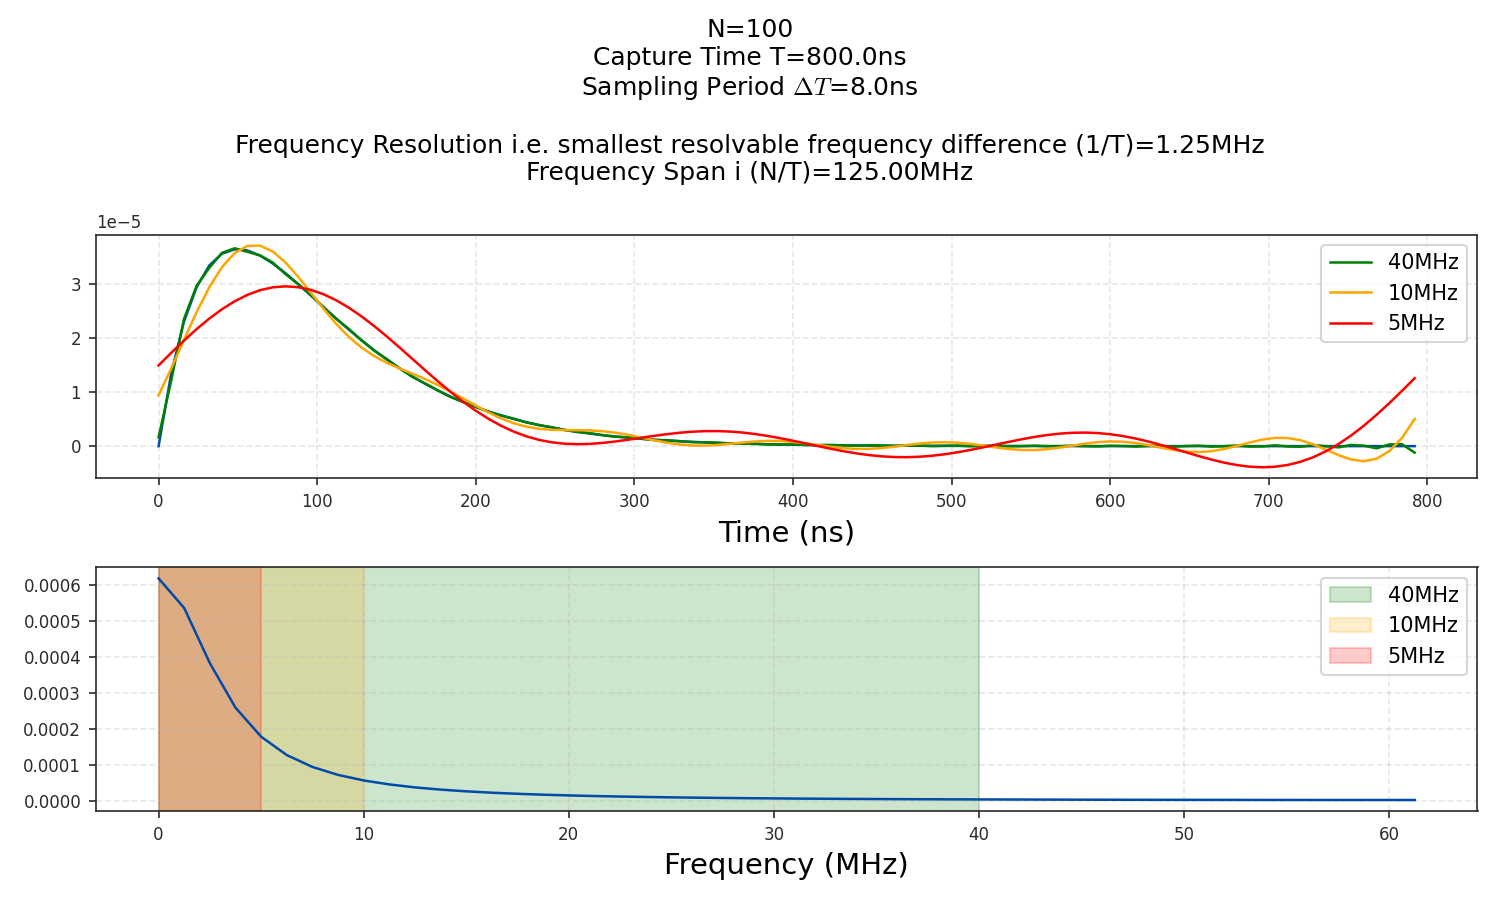

c:\users\astafiev experiment\appdata\local\programs\python\python38\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
c:\users\astafiev experiment\appdata\local\programs\python\python38\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
c:\users\astafiev experiment\appdata\local\programs\python\python38\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [5]:
# From notes, we have the following signal emerging from a qubit system
tmax = 800 * ns
N = 100

f_qubit = 100 * kHz # Hetrodyning
p_qubit = -40 #dBm after the signal leaves the system
T1 = 50 * ns

# Derived parametesr
v_qubit = dBm_to_V(p_qubit)
sampling_period = tmax / N

# Raw signal
time_scale = np.linspace(0, tmax, N, endpoint=False)
qubit_decay_signal = v_qubit * np.sin(2*np.pi * f_qubit* time_scale) * np.exp(-time_scale / T1)

# Brute force FFTW
POSITIVE_FREQUENCIES = int(N/2)
if N % 2:
    print("Odd FFTW")
    POSITIVE_FREQUENCIES = int(N - 1 / 2)    

freq_scale_in_hz = np.fft.fftfreq(N, d=sampling_period) # Scale by the frequency span (inverse of sampling_period)
fftw_qubit_decay_signal = fft(qubit_decay_signal)

# Analytical
# anal = 2 / (1 / T1 + T1 * (twoPi*freq_scale_in_hz - twoPi*f_qubit)**2) * 5000

fig, ax = plt.subplots(2, 1, figsize=(10,6))
ax[0].plot(time_scale / ns, qubit_decay_signal)
ax[0].set_xlabel("Time (ns)")

ax[1].plot(freq_scale_in_hz[:POSITIVE_FREQUENCIES] / MHz, np.abs(fftw_qubit_decay_signal)[:POSITIVE_FREQUENCIES])
# ax[1].plot(freq_scale_in_hz[:POSITIVE_FREQUENCIES] / MHz, np.abs(anal)[:POSITIVE_FREQUENCIES])
ax[1].set_xlabel("Frequency (MHz)");

def apply_filter(filt: float, color, label):
    # Then apply filter and transform back
    ax[1].axvspan(0, filt/MHz, color=color, alpha=0.2, label=label)
    
    filtered_list = []
    for (f, val) in zip(freq_scale_in_hz, fftw_qubit_decay_signal):
        if (np.abs(f) < filt):
            filtered_list.append(val)
        else:
            filtered_list.append(0)
            
    filtered_signal = ifft(filtered_list)
    ax[0].plot(time_scale / ns, filtered_signal, color=color, label=label)
        
apply_filter(40*MHz, "green", "40MHz")
apply_filter(10*MHz, "orange", "10MHz")
apply_filter(5*MHz, "red", "5MHz")
        
fig.suptitle(f"N={N}"+ "\n" 
             + f"Capture Time T={tmax/ns}ns" + "\n" 
             + f"Sampling Period $\Delta{{T}}$={tmax/ns/N}ns" + "\n\n" 
             + f"Frequency Resolution i.e. smallest resolvable frequency difference (1/T)={1/tmax/MHz:.2f}MHz" + "\n"
             + f"Frequency Span i (N/T)={1/sampling_period/MHz:.2f}MHz"
            );

ax[0].legend()
ax[1].legend()

plt.tight_layout();
plt.savefig("filtering-simulation.pdf")

# Playing with FFT

In [1]:
%matplotlib notebook

from scipy.fft import fft, ifft, fftfreq
import matplotlib.pyplot as plt
import numpy as np

N = 1000
tmax = 200

POSITIVE_FREQUENCIES = int(N/2)
if N % 2:
    print("Odd FFTW")
    POSITIVE_FREQUENCIES = int(N - 1 / 2)    

time_in_ns = np.linspace(0, tmax, N, endpoint=False)
freq_scale_in_mhz = fftfreq(N, tmax)[:POSITIVE_FREQUENCIES] * 1000

T1 = 40
print(f"Decay rate ={1/T1 * 10**3}MHz")
sin_signal = np.sin(2 * np.pi * 0.5 * time_in_ns)
decay_signal = np.exp(-time_in_ns/T1)

fftw_signal = fft(decay_signal)
fftw_sin = fft(sin_signal)

Decay rate =25.0MHz


In [2]:
# Example with sin
# fig, ax = plt.subplots(2, 1, figsize=(10,6))
# ax[0].plot(time_in_ns, sin_signal)
# ax[0].set_xlabel("Time (ns)");
# ax[0].set_ylabel("Amplitude (au)")

# ax[1].set_xlabel("Freq (MHz)");
# ax[1].set_ylabel("Amplitude (au)")
# ax[1].plot(
#     freq_scale_in_mhz,
#     np.real(fftw_sin)[:POSITIVE_FREQUENCIES], color="blue"
# )
# ax[1].plot(
#     freq_scale_in_mhz,
#     np.imag(fftw_sin)[:POSITIVE_FREQUENCIES], color="red"
# )
# ax[1].plot(
#     freq_scale_in_mhz,
#     np.abs(fftw_sin)[:POSITIVE_FREQUENCIES], color="green"
# )